# Using pre-trained models (PyTorch Version), Dr. Dimitris Mousadakos

In [1]:
# Make sure you have the necessary libraries installed
# !pip install torch torchvision matplotlib Pillow requests

## 1. Imports

In [25]:
import torch
from torchvision import models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import json

## 2. Check PyTorch Version


In [26]:
# 2. Check PyTorch Version
print(torch.__version__)

2.10.0


## 3. Load a Pre-trained Model

In [27]:
# =============================================================================
# Step 3: Load a Pre-trained Model & Labels
#
# We'll start with MobileNetV2
# torchvision.models provides many pre-trained models. We set `pretrained=True`
# to download the weights learned from the ImageNet dataset.
# We also set the model to evaluation mode (`.eval()`), which is important
# because it disables layers like Dropout that behave differently during
# training versus inference.
#
# We'll also download the ImageNet class labels to interpret the model's output.
# =============================================================================

In [28]:
# Load the MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.eval()

# Download ImageNet labels
labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_file = requests.get(labels_url).text
imagenet_labels = np.array(labels_file.splitlines())

# The original notebook had an extra "background" class at the start.
# PyTorch models output 1000 classes, so we align our labels with that.
imagenet_labels_pytorch = imagenet_labels[1:] # Skip the first "background" label.

## 4. Image Preprocessing Pipeline

In [29]:
# =============================================================================
# Step 3: Image Preprocessing Pipeline
#
# PyTorch models require a specific input format:
# 1. Images must be resized to a fixed size (e.g., 224x224).
# 2. They need to be converted to a PyTorch Tensor.
# 3. They MUST be normalized using the same mean and standard deviation
#    that were used when the model was trained on ImageNet.
#
# We define a `transform` pipeline to handle these steps automatically.
# =============================================================================

In [30]:
IMAGE_SHAPE = (224, 224)

# Define the standard ImageNet normalization transform
normalize_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(), # Converts image to a [0, 1] tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std dev
])

# Let's also create a transform pipeline WITHOUT normalization for the exercise.
simple_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

## 5. Download and Prepare Images

In [31]:
# =============================================================================
# Step 5: Download and Prepare Images
#
# We'll use the same Grace Hopper image and an image with multiple animals.
# =============================================================================

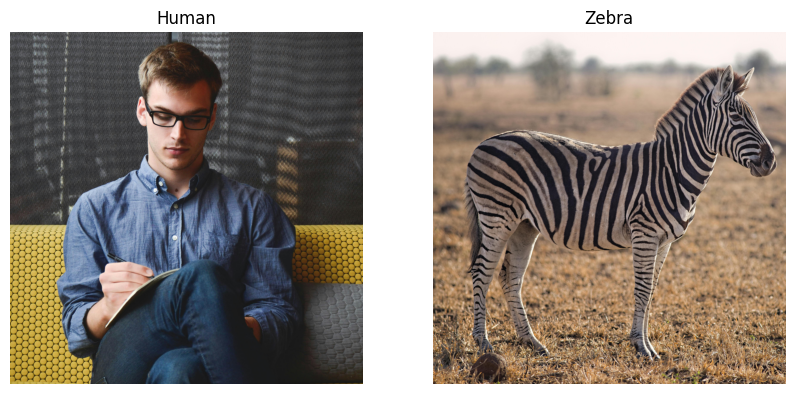

In [32]:
# --- Image 1: Human ---
human_url = 'https://images.pexels.com/photos/39866/entrepreneur-startup-start-up-man-39866.jpeg'
human_img_raw = Image.open(requests.get(human_url, stream=True).raw)
width, height = human_img_raw.size
smallest_dim = min(width, height)
square_cropper = transforms.CenterCrop(smallest_dim)
human_img = square_cropper(human_img_raw)


# --- Image 2: Multiple Animals ---
# The original notebook used a local file. We'll download a similar one.
animals_url = 'https://images.pexels.com/photos/750539/pexels-photo-750539.jpeg'
animals_img_raw = Image.open(requests.get(animals_url, stream=True).raw)
width, height = animals_img_raw.size
smallest_dim = min(width, height)
square_cropper = transforms.CenterCrop(smallest_dim)
animals_img = square_cropper(animals_img_raw)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(human_img)
plt.title("Human")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(animals_img)
plt.title("Zebra")
plt.axis('off')
plt.show()


## 6. Create a Prediction Function

In [33]:
# =============================================================================
# Step 6: Create a Prediction Function
#
# This function will take a model, an image, the labels, and the transform
# pipeline. It will preprocess the image, get the model's prediction, and
# print the top 5 most likely classes with their probabilities.
# =============================================================================


In [34]:
def predict_and_display(model, img, labels, transform_pipeline, top_k=5):
    """
    Takes a model, image, labels, and transform, and prints top-k predictions.
    """
    # Preprocess the image
    img_t = transform_pipeline(img)
    # Add a batch dimension: [C, H, W] -> [1, C, H, W]
    # The model expects a batch of images, even if it's just one.
    batch_t = torch.unsqueeze(img_t, 0)

    # Get the model's raw output (logits)
    with torch.no_grad(): # Disable gradient calculation for faster inference
        logits = model(batch_t)

    # Convert logits to probabilities using the softmax function
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)

    # Get the top k predictions
    top_k_probs, top_k_indices = torch.topk(probabilities, top_k)
    top_k_labels = labels[top_k_indices]

    # --- Display Results ---
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Top Prediction: {top_k_labels[0].title()} ({top_k_probs[0]*100:.2f}%)")
    plt.show()

    print(f"--- Top {top_k} Predictions ---")
    for i in range(top_k):
        print(f"{i+1}: {top_k_labels[i].title():<20} (Probability: {top_k_probs[i]*100:.2f}%)")
    print("-" * 30)

## 7.  Run Predictions

In [35]:
# =============================================================================
# Step 7: Run Predictions
#
# First, we run the model on the `human_img` image.
# Then, we'll try the `multipleanimals` image.
# =============================================================================

--- Classifying Grace Hopper with MobileNetV2 ---


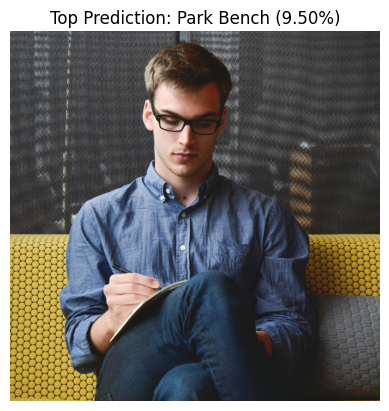

--- Top 5 Predictions ---
1: Park Bench           (Probability: 9.50%)
2: Bolo Tie             (Probability: 6.21%)
3: Sunglasses           (Probability: 5.14%)
4: Pajama               (Probability: 4.95%)
5: Stethoscope          (Probability: 4.00%)
------------------------------

--- Classifying Multiple Animals with MobileNetV2 ---


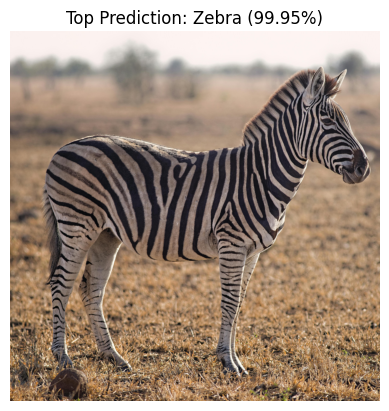

--- Top 5 Predictions ---
1: Zebra                (Probability: 99.95%)
2: Hartebeest           (Probability: 0.02%)
3: Impala               (Probability: 0.01%)
4: Gazelle              (Probability: 0.00%)
5: Lion                 (Probability: 0.00%)
------------------------------


In [36]:
print("--- Classifying Grace Hopper with MobileNetV2 ---")
predict_and_display(mobilenet_v2, human_img, imagenet_labels_pytorch, normalize_transform)

print("\n--- Classifying Multiple Animals with MobileNetV2 ---")
predict_and_display(mobilenet_v2, animals_img, imagenet_labels_pytorch, normalize_transform)


## 8. The Importance of Normalization

In [37]:
# =============================================================================
# Step 8: (EXERCISE) The Importance of Normalization
#
# What happens if you predict without normalizing the image? Let's try it.
# The pre-trained models were trained on normalized images, so they expect
# inputs in a specific numerical range. Using non-normalized data will
# almost always result in incorrect (and low-confidence) predictions.
#
# Here we use the `simple_transform` which only resizes and converts to a
# tensor, but does NOT normalize.
# =============================================================================

Notice how the prediction are changing.


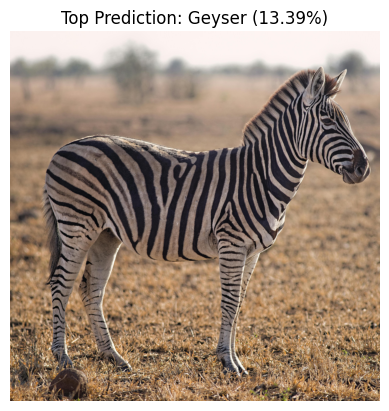

--- Top 5 Predictions ---
1: Geyser               (Probability: 13.39%)
2: Fountain             (Probability: 8.40%)
3: Shower Curtain       (Probability: 5.78%)
4: Toilet Tissue        (Probability: 4.68%)
5: Mosquito Net         (Probability: 4.53%)
------------------------------


In [38]:
print("Notice how the prediction are changing.")
predict_and_display(mobilenet_v2, animals_img, imagenet_labels_pytorch, simple_transform)

In [39]:
## 9. Predict using a different model

In [40]:
# =============================================================================
# Step 9: (EXTENSION) Using a Different Model
#
# Let's see how easy it is to switch models. We'll load ResNet-18, a different
# popular architecture. The prediction pipeline remains exactly the same!
#
# We will use the *normalized* transform, as that's how ResNet was trained too.
# =============================================================================



--- EXTENSION: Using a Different Model (ResNet-18) ---


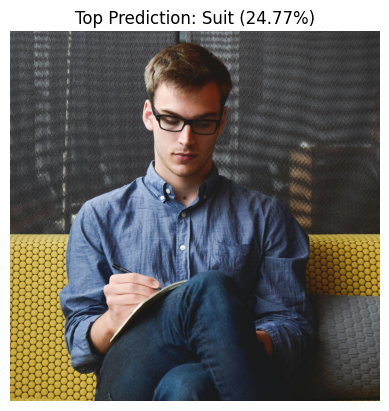

--- Top 5 Predictions ---
1: Suit                 (Probability: 24.77%)
2: Jean                 (Probability: 17.39%)
3: Windsor Tie          (Probability: 6.49%)
4: Seat Belt            (Probability: 2.12%)
5: Sleeping Bag         (Probability: 1.94%)
------------------------------

--- Classifying Multiple Animals with ResNet-18 ---


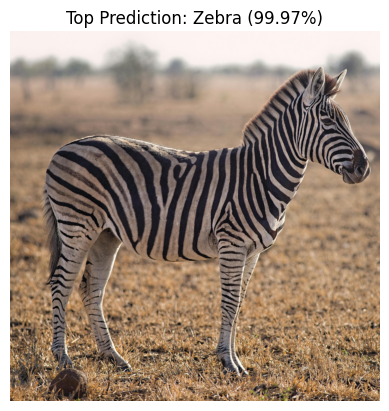

--- Top 5 Predictions ---
1: Zebra                (Probability: 99.97%)
2: Prairie Chicken      (Probability: 0.01%)
3: Cheetah              (Probability: 0.01%)
4: Tiger                (Probability: 0.00%)
5: Tiger Cat            (Probability: 0.00%)
------------------------------


In [42]:
print("\n\n--- EXTENSION: Using a Different Model (ResNet-18) ---")
weights = ResNet18_Weights.DEFAULT
resnet18 = models.resnet18(weights=weights)
resnet18.eval()

preprocess = weights.transforms()

predict_and_display(resnet18, human_img, imagenet_labels_pytorch, preprocess)

print("\n--- Classifying Multiple Animals with ResNet-18 ---")
predict_and_display(resnet18, animals_img, imagenet_labels_pytorch, preprocess)

## 10. Test with Your Own Image

In [21]:
# =============================================================================
# Step 10: (TASK) Test with Your Own Image
#
# 1. Find an image of an animal or object on the internet.
# 2. Copy its URL and paste it into the `my_image_url` variable below.
# 3. Run this cell to see the predictions from both MobileNetV2 and ResNet-18.
#
# See if they agree or if they give different results!
# =============================================================================



--- YOUR TASK: Classifying Your Image ---

--- Prediction with MobileNetV2 ---


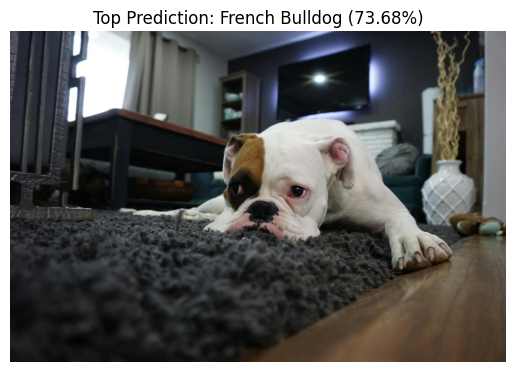

--- Top 5 Predictions ---
1: French Bulldog       (Probability: 73.68%)
2: Boxer                (Probability: 20.26%)
3: Boston Bull          (Probability: 1.95%)
4: Clumber              (Probability: 0.87%)
5: Chihuahua            (Probability: 0.51%)
------------------------------

--- Prediction with ResNet-18 ---


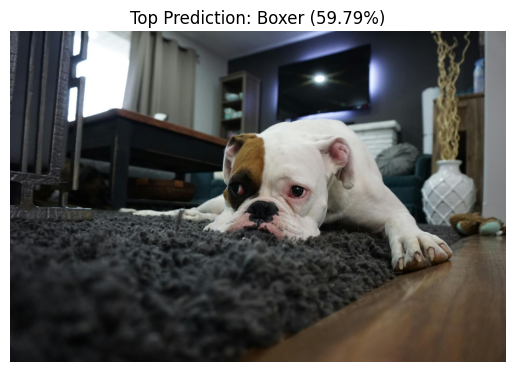

--- Top 5 Predictions ---
1: Boxer                (Probability: 59.79%)
2: French Bulldog       (Probability: 20.29%)
3: Blenheim Spaniel     (Probability: 3.83%)
4: Boston Bull          (Probability: 2.18%)
5: Pekinese             (Probability: 1.73%)
------------------------------


In [38]:
# --- PASTE YOUR IMAGE URL HERE ---
my_image_url = "https://images.pexels.com/photos/164446/pexels-photo-164446.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" # Example: A lion

try:
    my_image = Image.open(requests.get(my_image_url, stream=True).raw)

    print("\n\n--- YOUR TASK: Classifying Your Image ---")

    print("\n--- Prediction with MobileNetV2 ---")
    predict_and_display(mobilenet_v2, my_image, imagenet_labels_pytorch, normalize_transform)

    print("\n--- Prediction with ResNet-18 ---")
    predict_and_display(resnet18, my_image, imagenet_labels_pytorch, normalize_transform)

except Exception as e:
    print(f"Could not load the image from the URL. Please check the URL and try again. Error: {e}")

## 11. (TASK) Do the same without normalization